# Imports

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from scipy.stats import weibull_min, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import kaleido
import plotly.express as px
import math
import random
import tqdm
import plotly.graph_objects as go

# Befolkningsmodel

Denne model simulerer forekomsten og fordelingen af en sjælden genetisk sygdom hos nyfødte på tværs af forskellige lande over tid. Modellen inkorporerer forholdet mellem tilgængeligheden af genetisk testning og økonomisk udvikling, hvor Human Development Index (HDI) bruges som en proxy for sundhedssystemets kapacitet.

In [2]:
# Indlæs befolkningsdata 1950-2023, alle lande, 1-års intervaller
befolkning = pd.read_excel("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx", header=16)
befolkning = befolkning.loc[befolkning.Type == "Country/Area"].reset_index()
iso_to_reg = pd.read_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/iso_to_region.csv")
befolkning = befolkning.merge(
    iso_to_reg[['alpha-3', 'region']], 
    left_on='ISO3 Alpha-code',
    right_on='alpha-3',
    how='left'
)

# Tjek antallet af lande og år
print(f"Antal lande: {befolkning['ISO3 Alpha-code'].nunique()}")
print(f"Antal år: {befolkning['Year'].nunique()}")

# Yderligere tjek
print(f"Antal rækker: {befolkning.shape[0]}")
print(f"Antal kolonner: {befolkning.shape[1]}")

# indlæs HDI data 1990 - 2023 
hdi = pd.read_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/HDR23-24_Composite_indices_complete_time_series.csv", encoding='latin1')

Antal lande: 237
Antal år: 74
Antal rækker: 17538
Antal kolonner: 115


In [3]:
# Forbereder fremtidige data
befolkning_frem = pd.read_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/WPP2024_Demographic_Indicators_Medium.csv")
befolkning_frem = befolkning_frem[["ISO3_code","ISO2_code","Time","Births"]]
befolkning_frem = befolkning_frem.loc[befolkning_frem.Time>2023]
befolkning_frem = befolkning_frem.rename(columns={
    'ISO3_code': 'ISO3 Alpha-code',
    'ISO2_code': 'ISO2 Alpha-code', 
    'Time': 'Year',
    'Births':0
})
# Tilføj fremtidige befolkningsdata til befolkning
befolkning = pd.concat([befolkning, befolkning_frem], ignore_index=True)

# Sorter efter land og år for at sikre kronologisk rækkefølge
befolkning = befolkning.sort_values(['ISO3 Alpha-code', 'Year'])
static_columns = ['Variant', 'Region, subregion, country or area *', 'Notes', 
                 'Location code', 'SDMX code**', 'Type', 'region']
befolkning[static_columns] = befolkning.groupby('ISO3 Alpha-code')[static_columns].ffill()


# Udskriv verifikation af sammenfletning
print(f"Data spænder nu over år: {befolkning['Year'].min()} - {befolkning['Year'].max()}")
print(f"Antal lande: {befolkning['ISO3 Alpha-code'].nunique()}")

/var/folders/gg/176d9m9d78n1sckp6xcdmv8r0000gn/T/ipykernel_1995/3514160352.py:2: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  befolkning_frem = pd.read_csv("/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/populationsdata/WPP2024_Demographic_Indicators_Medium.csv")


Data spænder nu over år: 1950.0 - 2101.0
Antal lande: 237


# 1. HDI-Integration og Fremskrivning
Modellen anvender historisk HDI-data (1990-2022) og implementerer avancerede fremskrivningsmetoder:

Før 1956: Sat til 0 (før Lowe syndrom blev opdaget)
1956-1990: Lineær interpolation fra minimum HDI til første tilgængelige HDI-værdi
1990-2022: Bruger faktisk historisk HDI-data
Efter 2022: Fremskriver HDI-værdier ved hjælp af landespecifikke vækstrater

In [4]:
# Få liste over HDI-kolonner for år 1990-2023
hdi_cols = [f'hdi_{year}' for year in range(1990, 2023)]

# Vælg iso3-kolonne og alle HDI-kolonner
hdi = hdi[['iso3'] + hdi_cols]

# Sammenflet HDI-data med befolkningsdata
befolkning = befolkning.merge(hdi, left_on='ISO3 Alpha-code', right_on='iso3', how='left')

# Justér derefter listen over HDI-kolonner baseret på de faktiske kolonne navne
# For eksempel, hvis kolonnerne er navngivet som 'HDI_1990' i stedet for 'hdi_1990':
hdi_cols = [col for col in hdi.columns if col.startswith('HDI_') or col.startswith('hdi_')]

# Gå nu videre med sammenfletningen og udfyldningen
for col in hdi_cols:
    # Beregn regionale gennemsnit for nuværende HDI-år, med undtagelse af NaN-værdier
    regional_means = befolkning.groupby('region')[col].mean()
    
    # For hver region, udfyld NaN-værdier med det regionale gennemsnit
    for region in befolkning['region'].dropna().unique():
        region_mask = befolkning['region'] == region
        region_mean = regional_means[region]
        befolkning.loc[region_mask, col] = befolkning.loc[region_mask, col].fillna(region_mean)

In [5]:
# ---------------------------------------------------------------------
# 1) HDI-hentning med interpolation
# ---------------------------------------------------------------------
def get_effective_hdi(row,
                     year_col='Year',
                     hdi_floor=0.15,
                     pre_discovery_year=1956,
                     reference_year=1992,
                     final_year=2022,
                     growth_rates=None):
    """
    Returnerer et HDI for row[year_col] med opdaterede regler:
      1) Hvis år < opdagelsesår => minimalt opdagelse => returnerer 0
      2) Hvis opdagelsesår <= år < referenceår => lineær interpolation
      3) Hvis 1990 <= år <= 2022 => brug historiske data
      4) Hvis år > 2022 => projicér frem med land-specifik vækstrate
    """
    year = int(row[year_col])
    
    # Tilfælde 1: Før opdagelse
    if year < pre_discovery_year:
        return 0.0
        
    # Tilfælde 2: Mellem opdagelse og referenceår
    if pre_discovery_year <= year < reference_year:
        total_years = reference_year - pre_discovery_year
        years_from_discovery = year - pre_discovery_year
        # Lineær interpolation fra hdi_floor til første tilgængelige HDI
        first_hdi = row.get('hdi_1990', 0.5)  # fallback til 0.5 hvis mangler
        return hdi_floor + (first_hdi - hdi_floor) * (years_from_discovery / total_years)
    
    # Tilfælde 3: Historiske HDI-data (1990-2022)
    if 1990 <= year <= final_year:
        hdi_col = f'hdi_{year}'
        return row.get(hdi_col, 0.5)  # fallback til 0.5 hvis mangler
    
    # Tilfælde 4: Fremtidige projekter
    if year > final_year:
        # Få basis-HDI-værdi fra 2022
        base_hdi = row.get('hdi_2022', 0.5)  # fallback til 0.5 hvis mangler
        
        # Få land-specifik vækstrate (eller default til globalt gennemsnit)
        country_code = row['ISO3 Alpha-code']
        growth_rate = growth_rates.get(country_code, 0.005)  # default 0.5% årlig vækst
        
        # Beregn projektions-HDI
        years_forward = year - final_year
        projected_hdi = base_hdi * (1 + growth_rate) ** years_forward
        
        # Kap på 1.0 og gulv på hdi_floor
        return min(1.0, max(hdi_floor, projected_hdi))

def calculate_hdi_growth_rates(df):
    """
    Beregner gennemsnitlige årlige HDI-vækstrater for hvert land fra 1990-2022.
    Returnerer et dictionary med {landskode: vækstrate}.
    """
    growth_rates = {}
    
    for _, row in df.drop_duplicates('ISO3 Alpha-code').iterrows():
        country = row['ISO3 Alpha-code']
        
        # Få 1990 og 2022 HDI-værdier
        hdi_1990 = row.get('hdi_1990')
        hdi_2022 = row.get('hdi_2022')
        
        if pd.notna(hdi_1990) and pd.notna(hdi_2022) and hdi_1990 > 0:
            # Beregn sammensat årlig vækstrate
            years = 2022 - 1990
            growth_rate = (hdi_2022 / hdi_1990) ** (1/years) - 1
            growth_rates[country] = growth_rate
        else:
            # Brug globalt gennemsnit eller default hvis manglende data
            growth_rates[country] = 0.005  # 0.5% default vækst
    
    return growth_rates

# Beregn vækstrater
hdi_growth_rates = calculate_hdi_growth_rates(befolkning)

# Anvend funktionen til at få projektions-HDI-værdier
befolkning['projected_hdi'] = befolkning.apply(
    lambda row: get_effective_hdi(
        row, 
        growth_rates=hdi_growth_rates
    ), 
    axis=1
)

# 2. Model for Generering af Tilfælde
Modellen benytter en Zero-Inflated Poisson (ZIP) fordeling til at generere nye tilfælde:
Parametre:

Basis-incidensrate: 1/20.000 fødsler
Sandsynlighed for nul-inflation: (1 - HDI) for hvert land
Forventede tilfælde: Befolkning_alder0 * incidensrate * (1 + HDI)

ZIP-modellen tager højde for:

Underrapportering i lande med lavere HDI
Komplet fravær af tilfælde før sygdommens opdagelse (1956)
Øgede detektionsrater i lande med højere HDI

For hvert genereret tilfælde simulerer modellen individuelle livscyklusser ved hjælp af:

Weibull-fordeling til overlevelsesmodellering

Formparameter: 2,0 (definerer fordelingens form)
Skaleringsparameter: 55,0 (påvirker den gennemsnitlige overlevelsestid)


Sporer for hvert individ:

Fødselsår
Oprindelsesland
Overlevelsestatus
Nuværende alder



In [64]:
# ---------------------------------------------------------------------
# 2) Zero-inflated Poisson for nye (alder-0) tilfælde
# ---------------------------------------------------------------------
def simulate_cases_for_row(row,
                           incidence_rate=1/200000,
                           disease_discovery_year=1956,
                           year_col='Year',
                           pop_col=0):
    """
    Række-niveau ZIP-logik:
      - Hvis år < opdagelse => 0
      - Ellers HDI = get_effective_hdi(...)
        zero_infl_prob = 1 - HDI
        strukturel nul => tilfældig kontrol
        ellers Poisson( pop_age0 * incidence_rate * (1 + HDI) )
    Bemærk: pop_col refererer til kolonnen med nyfødte befolkning (sat til '0' som standard).
          multiplicer med 1000 hvis nødvendigt, osv.
    """

    year = int(row[year_col])
    # Eksempel: behandle 'pop_col' kolonnen som *tusinder* => multiplicer med 1000
    pop_age0 = row.get(pop_col, 0) * 1000  
    if pd.isna(pop_age0) or pop_age0 <= 0:
        return 0

    # Hvis år < disease_discovery_year => 0
    if year < disease_discovery_year:
        return 0

    # få HDI
    hdi_current = row['projected_hdi']

    # zero-inflation
    zero_infl_prob = 1.0 - hdi_current
    zero_infl_prob = max(0.0, min(1.0, zero_infl_prob))

    # strukturel nul kontrol
    if np.random.random() < zero_infl_prob:
        return 0

    # Poisson middelværdi
    lam = pop_age0 * incidence_rate * (1.0 + hdi_current)
    return np.random.poisson(lam)


def simulate_cases_for_dataframe(befolkning,
                                 incidence_rate=1/200000,
                                 disease_discovery_year=1956,
                                 year_col='Year',
                                 pop_col=0):
    """
    Anvender simulate_cases_for_row på hver række af 'befolkning',
    gemmer resultatet i 'simulated_cases'.
    """
    df = befolkning.copy()
    df['simulated_cases'] = df.apply(
        simulate_cases_for_row,
        axis=1,
        incidence_rate=incidence_rate,
        disease_discovery_year=disease_discovery_year,
        year_col=year_col,
        pop_col=pop_col
    )
    return df


# ---------------------------------------------------------------------
# 3) Individuel overlevelse med Weibull
# ---------------------------------------------------------------------
def draw_weibull_lifespan(shape=2.0, scale=55.0):
    """
    Tegn en tilfældig levetid T fra Weibull(shape, scale),
    ved hjælp af NumPy's np.random.weibull som kun bruger formen.
    Vi vil multiplicere med skalaen for at inkorporere skala-parametret.
    """
    raw = np.random.weibull(shape)
    T = scale * raw
    return T

def simulate_individuals_lifecycle(df_cases, 
                                   start_year, 
                                   end_year,
                                   shape=2.0,
                                   scale=55.0):
    """
    1) df_cases: en DataFrame med kolonner 'Year' og 'simulated_cases' 
       (antallet af nye tilfælde for det år).
    2) For hvert år i [start_year, end_year], gør vi følgende:
         - Tilføj nye individer => hver får en (fødselsår, dødsalder).
         - For hvert eksisterende individ, registrerer vi (år, alder, i live).
    3) Returnerer en 'timeline' DataFrame med kolonner:
         (year, individual_id, age, alive).
       Hvis alder >= dødsalder => ikke i live.
    """
    # Byg en dictionary: { år -> new_cases_count }
    test = df_simulated.loc[df_simulated['simulated_cases']>0]
    new_cases_dict = {}
    all_pairs = set()  # gem (land, region) par vi ser
    for idx, row in test.iterrows():
        c = row['ISO2 Alpha-code']
        r = row['region']
        y = row['Year']
        s = row['simulated_cases']
        iso3 = row['ISO3 Alpha-code']
        new_cases_dict[(c, r, y)] = (s, iso3)
        all_pairs.add((c, r))

    # 2) Masterliste over individer
    # Vi gemmer hver som en dictionary: {id, country, region, birth_year, death_age}
    individuals_list = []

    # Vi vil også gemme en tidsplan: år x individ => (age, alive)
    timeline_rows = []


      # 3) Gennemløb hvert simuleringsår
    for current_year in range(start_year, end_year+1):

        # A) For hver (land, region), tilføj nye individer hvis nogen
        for (country, region) in all_pairs:
            cases_data = new_cases_dict.get((country, region, current_year), (0, None))
            c_new = cases_data[0]
            iso3_code = cases_data[1]
            for _ in range(c_new):
                lifespan = draw_weibull_lifespan(shape, scale)
                patient_id = str(uuid.uuid4())  # generer en unik UUID
                individuals_list.append({
                    'patient_uuid': patient_id,
                    'country': country,
                    'region': region,
                    'birth_year': current_year,
                    'death_age': lifespan,
                    'iso3': iso3_code
                })

        # B) For hvert individ, se om de er i live i current_year
        for person in individuals_list:
            if person['birth_year'] > current_year:
                # ikke født endnu
                continue
            age = current_year - person['birth_year']
            alive = (age < person['death_age'])
            timeline_rows.append({
                'year': current_year,
                'country': person['country'],
                'region': person['region'],
                'patient_uuid': person['patient_uuid'],
                'age': age,
                'alive': alive,
                'iso3': person['iso3']
            })

    timeline_df = pd.DataFrame(timeline_rows)
    return timeline_df


# ---------------------------------------------------------------------
# Simuleringskørsel
# ---------------------------------------------------------------------
if __name__ == "__main__":

    # 1) Kør zero-inflated Poisson for at få 'simulated_cases'
    df_simulated = simulate_cases_for_dataframe(befolkning, incidence_rate=1/200000)

    # 2) Simuler nu individer fra år=1955 til år=2060
    timeline = simulate_individuals_lifecycle(
        df_cases=df_simulated, 
        start_year=1955, 
        end_year=2060,
        shape=2.0,
        scale=55.0
    )
timeline.loc[(timeline.alive == True)&(timeline.year==2023)].groupby("region").alive.count()

region
Africa       4593
Americas     3909
Asia        13256
Europe       2374
Oceania       161
Name: alive, dtype: int64

In [65]:
timeline.loc[(timeline.alive == True)&(timeline.year==2023)].groupby("region").alive.count().sum()

24293

# Modellen inkluderer analyse af godkendelsesbølger for potentielle behandlinger:

Bølge 1 (2030):

USA og EU/EØS-lande
Umiddelbar adgang ved godkendelse


Bølge 2 (2033):

Australien, Canada, Brasilien, Sydkorea, Taiwan, Japan
3 års forsinkelse fra initial godkendelse


Bølge 3 (2032):

Saudi-Arabien, Israel, UAE, Schweiz
2 års forsinkelse fra initial godkendelse

In [66]:
# Definer bølger og deres respektive forsinkelser fra US-godkendelse (brugt 2030 som basisår)
BØLGER = {
    'Bølge 1': {
        'lande': ['USA'] + 
                    ['DEU', 'FRA', 'ITA', 'ESP', 'BEL', 'NLD', 'AUT', 'DNK', 'SWE', 'FIN', 'NOR', 'IRL', 'ISL', 'LIE',
                     'PRT', 'GRC', 'POL', 'CZE', 'HUN', 'SVK', 'SVN', 'EST', 'LVA', 'LTU', 'ROU', 'BGR', 'HRV', 'MLT', 'CYP', 'LUX'],  # Alle EU + EØS
        'forsinkelse': 0  # US + EU (cirka 1 år forskel, men vi behandler det som samme bølge)
    },
    'Bølge 2': {
        'lande': ['AUS', 'CAN', 'BRA', 'KOR', 'TWN', 'JPN'],  # Kombinerer tidligere Bølge 3 & 4
        'forsinkelse': 3  # ~3 år efter US
    },
    'Bølge 3': {
        'lande': ['SAU', 'ISR', 'ARE', 'CHE'],  # Saudi-Arabien, Israel, UAE, Schweiz
        'forsinkelse': 2  # ~2 år efter US
    }
}

# Funktion til at analysere patienter efter bølge
def analyse_bølger(timeline_df, basisår=2030):
    resultater = {}
    
    for bølge_navn, bølge_info in BØLGER.items():
        bølge_år = basisår + bølge_info['forsinkelse']
        
        # Filter for den specifikke bølges lande, år og alder < 21
        bølge_patienter = timeline_df[
            (timeline_df['iso3'].isin(bølge_info['lande'])) &
            (timeline_df['year'] == bølge_år) &
            (timeline_df['age'] < 21) &
            (timeline_df['alive'] == True)
        ]
        
        # Få land-specifik udbrud
        land_tællinger = bølge_patienter.groupby('iso3').size()
        
        resultater[bølge_navn] = {
            'år': bølge_år,
            'total_patienter': len(bølge_patienter),
            'land_udbrud': land_tællinger.to_dict(),
            'lande': bølge_info['lande']
        }
    
    return resultater

# Kør analyse
bølge_resultater = analyse_bølger(timeline)

# Udskriv detaljerede resultater
print("\nPatientfordeling over Godkendelsesbølger (Basisår: 2030)")
print("-" * 70)
for bølge, data in bølge_resultater.items():
    print(f"\n{bølge} (År {data['år']}):")
    print(f"Totalt patienter under 21: {data['total_patienter']}")
    print("Landudbrud:")
    for land, tælling in data['land_udbrud'].items():
        print(f"  {land}: {tælling} patienter")
    print(f"Lande uden patienter: {set(data['lande']) - set(data['land_udbrud'].keys())}")


Patientfordeling over Godkendelsesbølger (Basisår: 2030)
----------------------------------------------------------------------

Bølge 1 (År 2030):
Totalt patienter under 21: 1377
Landudbrud:
  AUT: 14 patienter
  BEL: 19 patienter
  BGR: 5 patienter
  CYP: 1 patienter
  CZE: 16 patienter
  DEU: 152 patienter
  DNK: 10 patienter
  ESP: 43 patienter
  EST: 3 patienter
  FIN: 11 patienter
  FRA: 110 patienter
  GRC: 12 patienter
  HRV: 4 patienter
  HUN: 14 patienter
  IRL: 10 patienter
  ISL: 1 patienter
  ITA: 80 patienter
  LTU: 5 patienter
  LVA: 4 patienter
  NLD: 27 patienter
  NOR: 9 patienter
  POL: 50 patienter
  PRT: 12 patienter
  ROU: 27 patienter
  SVK: 7 patienter
  SVN: 5 patienter
  SWE: 23 patienter
  USA: 703 patienter
Lande uden patienter: {'MLT', 'LUX', 'LIE'}

Bølge 2 (År 2033):
Totalt patienter under 21: 719
Landudbrud:
  AUS: 60 patienter
  BRA: 399 patienter
  CAN: 61 patienter
  JPN: 144 patienter
  KOR: 55 patienter
Lande uden patienter: {'TWN'}

Bølge 3 (År 20

In [67]:
def calculate_sales_and_patients(timeline_df, cost_per_treatment=3000000, start_year=2031, end_year=2050):
    sales_by_year = {}
    patients_by_year = {}
    cumulative_treated = set()  # Track patients who have received treatment
    
    # Define market penetration rates (example: increasing adoption over time)
    def penetration_rate(years_since_approval):
        if years_since_approval == 0:
            return 0.05  # % in first year
        elif years_since_approval == 1:
            return 0.2  # 50% in second year
        elif years_since_approval == 2:
            return 0.4  # 70% in third year
        elif years_since_approval == 3:
            return 0.6  # 70% in third year
        else:
            return 0.7  # 80% thereafter
    
    for year in range(start_year, end_year + 1):
        new_treated_this_year = 0
        
        for wave_name, wave_info in BØLGER.items():
            approval_year = start_year + wave_info['forsinkelse']
            
            # Skip if treatment not yet approved for this wave
            if year < approval_year:
                continue
                
            years_since_approval = year - approval_year
            current_penetration = penetration_rate(years_since_approval)
            
            # Get eligible patients (alive, under 21, in approved countries, not previously treated)
            eligible_patients = timeline_df[
                (timeline_df['iso3'].isin(wave_info['lande'])) &
                (timeline_df['year'] == year) &
                (timeline_df['age'] < 21) &
                (timeline_df['alive'] == True)
            ]
            
            # Filter out already treated patients
            new_eligible = [p for p in eligible_patients['patient_uuid'].unique() 
                           if p not in cumulative_treated]
            
            # Apply penetration rate to calculate newly treated patients
            newly_treated = int(len(new_eligible) * current_penetration)
            new_treated_this_year += newly_treated
            
            # Add newly treated patients to the cumulative set
            cumulative_treated.update(new_eligible[:newly_treated])
        
        # Calculate sales for this year
        sales_by_year[year] = new_treated_this_year * cost_per_treatment
        patients_by_year[year] = new_treated_this_year
    
    return sales_by_year, patients_by_year, len(cumulative_treated)

In [68]:
# Calculate projections
sales_projection, patients_projection, total_treated = calculate_sales_and_patients(timeline, cost_per_treatment=3000000)

# Find peak sales year
peak_year = max(sales_projection, key=sales_projection.get)
peak_sales = sales_projection[peak_year]
peak_patients = patients_projection[peak_year]

print(f"\nSales and Patient Projection ($3,000,000 per treatment)")
print("-" * 70)
print(f"Peak year: {peak_year}")
print(f"Peak sales amount: ${peak_sales:,}")
print(f"Peak patients treated: {peak_patients:,}")
print(f"Total patients treated by 2050: {total_treated:,}")
print("\nYearly Projection:")
print(f"{'Year':<6}{'Patients':<10}{'Sales':>15}")
print("-" * 31)
for year, sales in sorted(sales_projection.items()):
    patients = patients_projection[year]
    print(f"{year:<6}{patients:<10}${sales:>14,}")


Sales and Patient Projection ($3,000,000 per treatment)
----------------------------------------------------------------------
Peak year: 2034
Peak sales amount: $1,539,000,000
Peak patients treated: 513
Total patients treated by 2050: 4,207

Yearly Projection:
Year  Patients            Sales
-------------------------------
2031  66        $   198,000,000
2032  262       $   786,000,000
2033  449       $ 1,347,000,000
2034  513       $ 1,539,000,000
2035  434       $ 1,302,000,000
2036  428       $ 1,284,000,000
2037  365       $ 1,095,000,000
2038  230       $   690,000,000
2039  138       $   414,000,000
2040  136       $   408,000,000
2041  120       $   360,000,000
2042  112       $   336,000,000
2043  118       $   354,000,000
2044  116       $   348,000,000
2045  119       $   357,000,000
2046  131       $   393,000,000
2047  121       $   363,000,000
2048  117       $   351,000,000
2049  112       $   336,000,000
2050  120       $   360,000,000


In [60]:
sum(sales_projection.values())/1e9

5.133

In [69]:
sum(sales_projection.values())/1e9

12.621

In [63]:
# Create a figure with two y-axes
fig = go.Figure()

# Add bars for patient numbers
fig.add_trace(go.Bar(
    x=list(patients_projection.keys()),
    y=list(patients_projection.values()),
    name='Patients Treated',
    marker_color='#2F6CD6',
    opacity=0.7
))

# Create a secondary Y-axis for sales (in millions)
fig.add_trace(go.Scatter(
    x=list(sales_projection.keys()),
    y=[sales/1000000 for sales in sales_projection.values()],
    name='Sales ($ millions)',
    marker_color='#FF6347',
    mode='lines+markers',
    line=dict(width=3),
    yaxis='y2'
))

# Update the layout
fig.update_layout(
    title='Yearly Patients Treated and Sales Projection',
    xaxis_title='Year',
    yaxis_title='Number of Patients',
    yaxis2=dict(
        title='Sales ($ millions)',
        overlaying='y',
        side='right'
    ),
    width=1000,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    barmode='group'
)

# Show the figure
fig.show()

# Save the figure for future reference
fig.write_image("./output/sales_and_patients_projection.png", scale=2, format="png")

FileNotFoundError: [Errno 2] No such file or directory: 'output/sales_and_patients_projection.png'

# Figurer

In [ ]:
# Opret en brugerdefineret farveskala med dine farver
custom_colors = [
    '#F1ECE2',  # Elfenben
    '#2F6CD6',  # Ultramarin Blå
]

alive_2023 = timeline.loc[
    (timeline.alive == True) & 
    (timeline.year == 2023)
].merge(
    befolkning[['ISO2 Alpha-code', 'ISO3 Alpha-code']].drop_duplicates(),
    left_on='country',
    right_on='ISO2 Alpha-code'
)

alive_2023 = alive_2023.groupby('ISO3 Alpha-code').size().reset_index(name='count')

# Opret en kopi med begrænsede værdier
alive_2023_capped = alive_2023.copy()
alive_2023_capped['count_capped'] = alive_2023_capped['count'].clip(upper=100)

fig = px.choropleth(
    alive_2023_capped,
    locations='ISO3 Alpha-code',
    locationmode='ISO-3',
    color='count_capped',
    hover_data=['count'],
    hover_name='ISO3 Alpha-code',
    color_continuous_scale=custom_colors,
    title='Antal levende patienter pr. land i 2023 (Værdier begrænset til 100+)',
    range_color=[0, 100]
)

fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    width=1000,
    height=600,
    coloraxis_colorbar_title="Patienter",
    # Opdater farvebærbare ticks for at vise 100+
    coloraxis_colorbar=dict(
        ticktext=['0', '25', '50', '75', '100+'],
        tickvals=[0, 25, 50, 75, 100],
    )
)

# Opdater hover-skabelon for at vise både begrænsede og originale værdier
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Patienter: %{customdata[0]}<br>' +
                  '<extra></extra>'
)



fig.show()

# Opdater layout for at inkludere gennemsigtig baggrund
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Gennemsigtig baggrund
    plot_bgcolor='rgba(0,0,0,0)',   # Gennemsigtig plotområde
    title_x=0.5,
    geo=dict(
        showframe=False, 
        showcoastlines=True, 
        projection_type='equirectangular',
        bgcolor='rgba(0,0,0,0)'  # Gennemsigtig baggrund for kortet
    ),
    width=1000,
    height=600
)

# Gem figuren med gennemsigtig baggrund
fig.write_image("./output/world_map_patients_2023.png", scale=2, format="png")

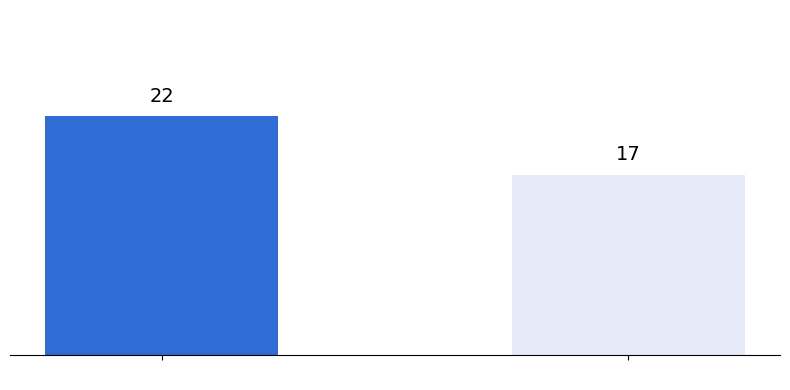

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# === Data ===
your_team_h = [67, 27, 25, 18, 20, 13]
purespring_h = [74, 3, 17]
baseline_h = [35, 3, 5, 26, 2, 5, 48, 6, 4, 4, 2, 14, 6, 13, 9, 3]

your_team_median = np.median(your_team_h)  # 22.5 -> visually rounded down
purespring_median = np.median(purespring_h)  # 17
baseline_median = np.median(baseline_h)  # 5.5

# === Colors ===
main_blue = "#2F6CD6"     # Your Team
light_blue = "#E4EAF7"    # Purespring and baseline line

# === Plot ===
labels = [" ", ""]
values = [your_team_median, purespring_median]
colors = [main_blue, light_blue]

plt.figure(figsize=(8, 4), facecolor='none')
plt.gca().set_facecolor('none')
bars = plt.bar(labels, values, color=colors, width=0.5)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{int(yval)}", ha='center', va='bottom', fontsize=14)

# Baseline median line
#plt.axhline(y=baseline_median, color="#262626", linewidth=2)
#plt.text(1.05, baseline_median + 0.5, f"{baseline_median:.1f}*", color=light_blue, fontsize=12)
#plt.text(1.95, baseline_median + 0.5, "6*", color=light_blue, fontsize=12)  # Added text label at the end of the baseline median line

# Minimal styling
for spine in ["top", "right", "left"]:
    plt.gca().spines[spine].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks([])  # Hide y-axis ticks
plt.ylim(0, max(values) + 10)
plt.tight_layout()
plt.savefig('bar_chart.png', transparent=True, bbox_inches='tight')
plt.show()


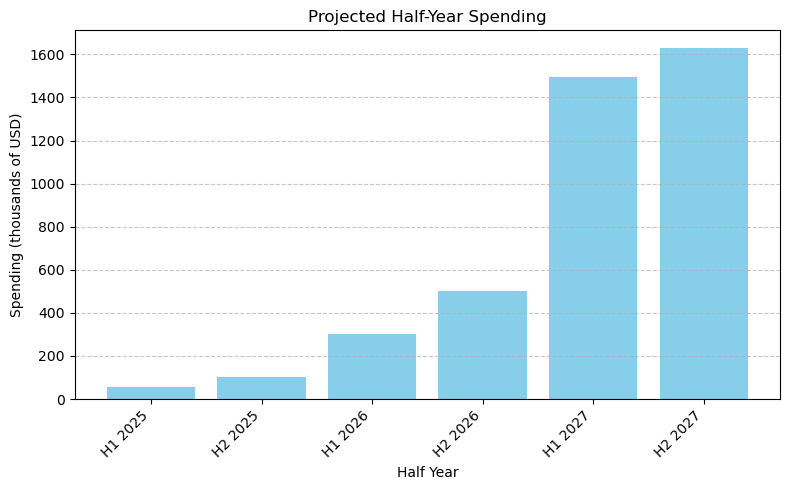

In [90]:
import matplotlib.pyplot as plt

# 1) Define your half-year allocation (in thousands of USD)
half_year_spend = {
    'H1 2025': 55.0,    # Q1+Q2 (10k + 22.5k + 22.5k)
    'H2 2025': 100.0,    # Q3+Q4 (10k + 10k)
    'H1 2026': 300.0,   # Q1+Q2 (0 + 300k)
    'H2 2026': 500.0,   # Q3+Q4 (300k + 0)
    'H1 2027': 1495.0,  # Q1+Q2 (267.5k + 1160k + 267.5k)
    'H2 2027': 1630.0   # Q3+Q4 (1160k + 235k + 235k)
}

# 2) Prepare labels and data in the order you want them displayed
half_year_labels = list(half_year_spend.keys())
spend_values = [half_year_spend[h] for h in half_year_labels]

# 3) Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(half_year_labels, spend_values, color='skyblue')

# 4) Labeling and style
plt.title("Projected Half-Year Spending")
plt.xlabel("Half Year")
plt.ylabel("Spending (thousands of USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 5) Display the chart
plt.show()